In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
import cv2
from tqdm import tqdm
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from pandas.io.json import json_normalize
from collections import Iterable

In [2]:
df_train=pd.read_json('labels/det_v2_train_release.json')
df_val=pd.read_json('labels/det_v2_val_release.json')

In [3]:
from keras.utils.np_utils import to_categorical
json_list = [j[1][5] for j in df_train.iterrows()]
train_attribute = pd.DataFrame(json_list)
train_attribute = pd.get_dummies(train_attribute)#turn data to categorical like format for image classification
train_attribute = to_categorical(train_attribute, 9)
#print(train_attribute)
#   rainy        snowy        clear   overcast    undefined  partly cloudy    foggy
#  tunnel  residential  parking lot  undefined  city street   gas stations  highway
# daytime        night         dawn       dusk    undefined

2023-02-13 21:11:30.209527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 21:11:30.376122: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-13 21:11:31.211772: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr

In [4]:
json_list = [j[1][5] for j in df_train.iterrows()]
train_attribute = pd.DataFrame(json_list)
print(train_attribute.head())

  weather  timeofday        scene
0   clear    daytime  city street
1   clear  dawn/dusk      highway
2   clear  dawn/dusk  residential
3   clear      night  city street
4   clear      night      highway


In [5]:
image_names = [j[1][0] for j in df_train.iterrows()]
result_train = pd.DataFrame(image_names)
result_train.to_csv("names.csv", index=False)
names_train=pd.read_csv('names.csv')
names_train.rename(columns={'0': 'name'}, inplace=True)
print(names_train.head())#labels_val.head())

                name
0  0000f77c-6257be58
1  0000f77c-62c2a288
2  0000f77c-cb820c98
3  0001542f-5ce3cf52
4  0001542f-7c670be8


In [6]:
df_train_concated=pd.concat([names_train, train_attribute], axis=1)
print(df_train_concated.head(10))

                name weather  timeofday        scene
0  0000f77c-6257be58   clear    daytime  city street
1  0000f77c-62c2a288   clear  dawn/dusk      highway
2  0000f77c-cb820c98   clear  dawn/dusk  residential
3  0001542f-5ce3cf52   clear      night  city street
4  0001542f-7c670be8   clear      night      highway
5  0001542f-ec815219   clear      night  city street
6  0004974f-05e1c285   rainy      night      highway
7  00054602-3bf57337   clear    daytime  city street
8  00067cfb-5443fe39   clear    daytime  city street
9  00067cfb-5adfaaa7   clear      night      highway


In [7]:
print("total train labels: ", len(df_train_concated['name']))

total train labels:  69863


In [8]:
root='bdd100k/bdd100k/images/100k'

In [11]:
df_train_concated = df_train_concated.replace('tunnel', 'highway')
df_train_concated = df_train_concated.loc[~((df_train_concated['weather'] == 'undefined') | (df_train_concated['scene'] == 'undefined') | (df_train_concated['timeofday'] == 'undefined') | (df_train_concated['scene'] == 'gas stations') | (df_train_concated['scene'] == 'parking lot'))]
print(df_train_concated.head(10))

                name weather  timeofday        scene
0  0000f77c-6257be58   clear    daytime  city street
1  0000f77c-62c2a288   clear  dawn/dusk      highway
2  0000f77c-cb820c98   clear  dawn/dusk  residential
3  0001542f-5ce3cf52   clear      night  city street
4  0001542f-7c670be8   clear      night      highway
5  0001542f-ec815219   clear      night  city street
6  0004974f-05e1c285   rainy      night      highway
7  00054602-3bf57337   clear    daytime  city street
8  00067cfb-5443fe39   clear    daytime  city street
9  00067cfb-5adfaaa7   clear      night      highway


In [12]:
print(df_train_concated['weather'].value_counts())
print(df_train_concated['scene'].value_counts())
print(df_train_concated['timeofday'].value_counts())
print("total train labels: ", len(df_train_concated['name']))

clear            36979
overcast          8696
snowy             5496
rainy             4987
partly cloudy     4846
foggy              129
Name: weather, dtype: int64
city street    37883
highway        16325
residential     6925
Name: scene, dtype: int64
daytime      29433
night        27235
dawn/dusk     4465
Name: timeofday, dtype: int64
total train labels:  61133


In [13]:
from sklearn.preprocessing import LabelEncoder

weather_encoder = LabelEncoder().fit(df_train_concated['weather'])
scene_encoder = LabelEncoder().fit(df_train_concated['scene'])
timeofday_encoder = LabelEncoder().fit(df_train_concated['timeofday'])

df_train_concated['weather'] = weather_encoder.transform(df_train_concated['weather'])
df_train_concated['scene'] = scene_encoder.transform(df_train_concated['scene'])
df_train_concated['timeofday'] = timeofday_encoder.transform(df_train_concated['timeofday'])
df_train_concated['name'] = df_train_concated['name'].str.replace('\\', '/', regex=True)

df_train_concated.head()

,name,weather,timeofday,scene
0,0000f77c-6257be58,0,1,0
1,0000f77c-62c2a288,0,0,1
2,0000f77c-cb820c98,0,0,2
3,0001542f-5ce3cf52,0,2,0
4,0001542f-7c670be8,0,2,1


In [14]:
df_train_concated.to_csv('bdd100k_classification.csv')

In [15]:
from sklearn.model_selection import train_test_split
import random
random_state = 42
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)
x_train, x_test, y_train, y_test = train_test_split(df_train_concated['name'].values, df_train_concated[['weather', 'scene', 'timeofday']].values, 
                                                    shuffle=True, 
                                                    random_state=random_state, 
                                                    stratify=df_train_concated['weather'])
y_test

array([[0, 0, 2],
       [0, 0, 0],
       [0, 1, 1],
       ...,
       [2, 1, 1],
       [0, 2, 1],
       [2, 0, 1]])

In [16]:
from albumentations import *
from albumentations.pytorch import ToTensorV2

transforms = {
    x: Compose([
        Resize(416, 416),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.2, border_mode=cv2.BORDER_REPLICATE),
        RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        OneOf([
            GaussianBlur(),
            GaussNoise(),
        ], p=0.2),

        Normalize(),
        ToTensorV2()
    ]) if x == 'train' else Compose([
        Resize(416, 416),
        
        Normalize(),
        ToTensorV2()
    ]) for x in ['train', 'test']
}

In [17]:
from torch.utils.data import DataLoader, Dataset
class CustomDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files=image_files
        self.labels=labels
        self.transform=transform
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, i):
        image = np.array(Image.open(os.path.join(root, 'train', self.image_files[i]+'.jpg')).convert('RGB'))
        labels = self.labels[i]
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
        
        return image, labels[0], labels[1], labels[2]

In [18]:
sets = {
    'train': (x_train, y_train), 'test': (x_test, y_test)
}

datasets = {
    x: CustomDataset(sets[x][0], sets[x][1], transforms[x]) for x in sets.keys() 
}

dataloaders = {
    x: DataLoader(datasets[x], batch_size=128, num_workers=12, pin_memory=True) for x in sets.keys()
}

In [19]:
class MultiOutputModel(torch.nn.Module):
    def __init__(self, num_classes1, num_classes2, num_classes3):
        super(MultiOutputModel, self).__init__()
        #self.model = EfficientNet.from_pretrained('efficientnet-b0')
        self.base_model = torchvision.models.mobilenet_v3_small(pretrained=True)
        #self.base_model.load_state_dict(torch.load('../input/mobilenetv3/mobilenet_v3_small-047dcff4.pth'))

        last_channel = self.base_model.classifier[-1].out_features
        #self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.model1 = nn.Sequential(
            nn.Linear(last_channel, 128),
            nn.ReLU(),
            nn.Linear(128,num_classes1),
            nn.ReLU())
        
        self.model2 = nn.Sequential(
            nn.Linear(last_channel, 128),
            nn.ReLU(),
            nn.Linear(128,num_classes2),
            nn.ReLU())
        
        self.model3 = nn.Sequential(
            nn.Linear(last_channel, 128),
            nn.ReLU(),
            nn.Linear(128,num_classes3),
            nn.ReLU())

    def forward(self, x):
        x = self.base_model(x)
        #x = self.pool(x)
        output_1 = self.model1(x)
        output_2 = self.model2(x)
        output_3 = self.model3(x)
        return output_1, output_2, output_3

model = MultiOutputModel(len(weather_encoder.classes_), len(scene_encoder.classes_), len(timeofday_encoder.classes_))

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn_1 = torch.nn.CrossEntropyLoss().to(device)
loss_fn_2 = torch.nn.CrossEntropyLoss().to(device)
loss_fn_3 = torch.nn.CrossEntropyLoss().to(device)
epochs = 10

In [22]:
from sklearn.metrics import accuracy_score

def train_fn(i, model, data_loader, loss_fn_1, loss_fn_2, loss_fn_3, optimizer, device):
    overall_loss = 0.
    
    with tqdm(data_loader, total=len(data_loader), desc=f'Training, phase {i} :') as loader:
        for data, weather, scene, timeofday in loader:
            optimizer.zero_grad()

            data, weather, scene, timeofday = data.to(device), weather.to(device), scene.to(device), timeofday.to(device)
            output_1, output_2, output_3 = model(data)
            loss_1 = loss_fn_1(output_1, weather)
            loss_2 = loss_fn_2(output_2, scene)
            loss_3 = loss_fn_3(output_3, timeofday)
            loss = 0.35*loss_1 + 0.3*loss_2 + 0.35*loss_3
            
            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

            loader.set_postfix(loss=overall_loss / len(data_loader))
            

def validation_fn(i, model, data_loader, device):
    model.eval()
    
    weather_accuracy = 0.
    scene_accuracy = 0.
    timeofday_accuracy = 0.
    
    with tqdm(data_loader, total=len(data_loader), desc=f'Validating, phase {i} :') as loader:
        with torch.no_grad():
            for data, weather, scene, timeofday in loader:
                data, weather, scene, timeofday = data.to(device), weather.to(device), scene.to(device), timeofday.to(device)

                output_1, output_2, output_3 = model(data)
                
                weather_accuracy += accuracy_score(weather.cpu().detach().numpy(), 
                                                  torch.argmax(output_1, dim=1).cpu().detach().numpy())
                
                scene_accuracy += accuracy_score(scene.cpu().detach().numpy(), 
                                                   torch.argmax(output_2, dim=1).cpu().detach().numpy())
                
                timeofday_accuracy += accuracy_score(timeofday.cpu().detach().numpy(), 
                                                   torch.argmax(output_3, dim=1).cpu().detach().numpy())

                loader.set_postfix(accuracy_weather=weather_accuracy / len(data_loader),
                                   accuracy_scene=scene_accuracy / len(data_loader),
                                   accuracy_timeofday=timeofday_accuracy / len(data_loader))
    model.train()

In [23]:
torch.cuda.empty_cache()
for epoch in range(1, epochs + 1):
    train_fn(epoch, model, dataloaders['train'], loss_fn_1, loss_fn_2, loss_fn_3, optimizer, device)
    validation_fn(epoch, model, dataloaders['test'], device)

Validating, phase 10 :: 100%|██████████| 120/120 [01:41<00:00,  1.18it/s, accuracy_scene=0.773, accuracy_timeofday=0.94, accuracy_weather=0.841]     


(720, 1280, 3)
torch.Size([1, 3, 416, 416])


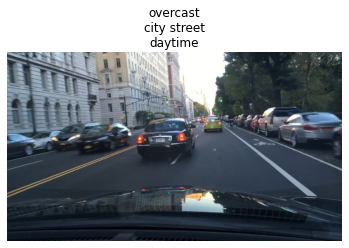

(720, 1280, 3)
torch.Size([1, 3, 416, 416])


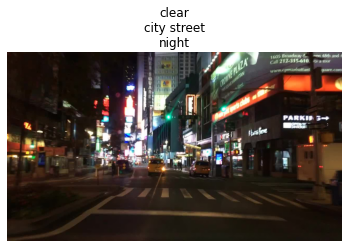

(720, 1280, 3)
torch.Size([1, 3, 416, 416])


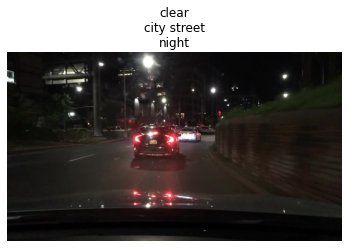

(720, 1280, 3)
torch.Size([1, 3, 416, 416])


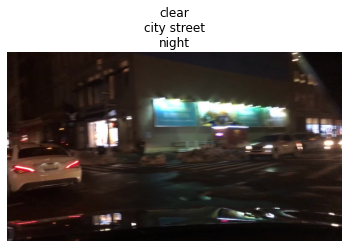

(720, 1280, 3)
torch.Size([1, 3, 416, 416])


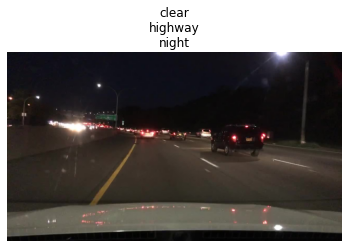

(720, 1280, 3)
torch.Size([1, 3, 416, 416])


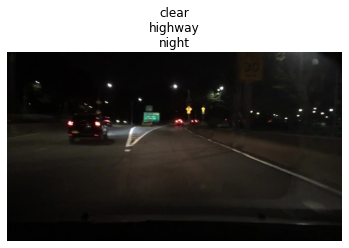

(720, 1280, 3)
torch.Size([1, 3, 416, 416])


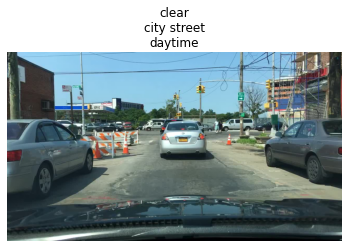

(720, 1280, 3)
torch.Size([1, 3, 416, 416])


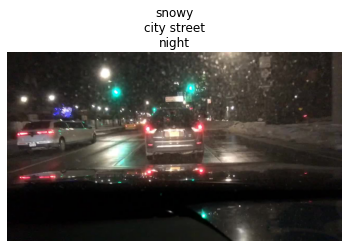

(720, 1280, 3)
torch.Size([1, 3, 416, 416])


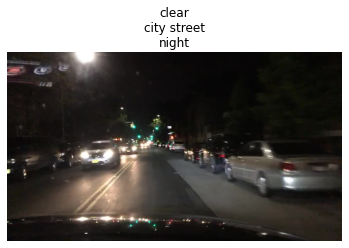

(720, 1280, 3)
torch.Size([1, 3, 416, 416])


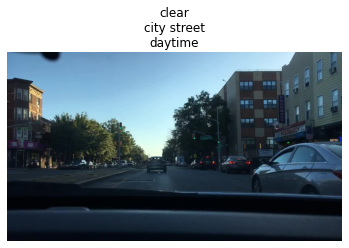

In [24]:
import glob
model.eval()

images = glob.glob(os.path.join(root, 'test', '*'))

for _ in range(10):
    image = np.array(Image.open(np.random.choice(images)).convert('RGB'))
    print(image.shape)
    
    tensor = transforms['test'](image=image)['image'].unsqueeze(0).to(device)
    print(tensor.shape)
    output1, output2, output3 = model(tensor)
    
    output1 = torch.argmax(output1, dim=1).cpu().detach().numpy()
    output2 = torch.argmax(output2, dim=1).cpu().detach().numpy()
    output3 = torch.argmax(output3, dim=1).cpu().detach().numpy()
    plt.imshow(image)
    plt.title(f"{weather_encoder.inverse_transform(output1)[0]}\n{scene_encoder.inverse_transform(output2)[0].lower()}\n{timeofday_encoder.inverse_transform(output3)[0].lower()}")
    plt.axis('off')
    plt.show()

In [26]:
torch.save(model.state_dict(), 'multioutput_mobilenet_v3_412.pt')